# Задание 3 (когортный анализ)
Приведите в качестве решения скриншот с результатом, а также свои комментарии относительно предложенного решения (с указанием среды, в которой решали
задания). В приложенном файле хранятся данные об активности клиентов с сентября 2021 года по февраль 2022
Необходимо на основе этих данных провести когортный анализ
Данные: data_test.csv
Описание полей:
- CLIENT_ID - идентификатор клиента;
- VALUE_DAY - отчетная дата;
- DIGITAL_30_CNT - кол-во входов в мобильное приложение за последние 30 дней на отчетную дату;
- TRAN_ACTIVE_30_CNT - кол-во транзакций в мобильном приложении за последние 30 дней на отчетную дату;
- OPER_ACTIVE_30_CNT - кол-во операций (транзакции+нефинансовые операции) в мобильном приложении за последние 30 дней на отчетную дату
1) постройте визуальное представление удержания клиентов в статусе: активных клиентов банка (наличие строки для клиента на отчетную дату); диджитал активных (активных в мобильном приложении: наличие хотя бы одного входа); операционно активных; транзакционно активных;
2) какие выводы можно сделать на основе этих данных?;
3) если построить проникновение транзакционно активных клиентов в когорты диджитал активных клиентов, то мы увидим, что существенная часть клиентов использует мобильное приложение, но не совершает транзакции (платежи и переводы) в нем. Какие гипотезы такого поведения можно предположить? Как их можно проверить?;
4) как можно исправить эту ситуацию и увеличить проникновение транзакционно активных клиентов в диджитал активных?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pip install subplot --upgrade

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement subplot (from versions: none)
ERROR: No matching distribution found for subplot


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Propsih/test/main/data_test.csv', sep=';')
display(data.head(10))  # или просто display(data)

,CLIENT_ID,VALUE_DAY,DIGITAL_30_CNT,TRAN_ACTIVE_30_CNT,OPER_ACTIVE_30_CNT
0,3596869440,30.09.2021,18.0,8.0,9.0
1,181778433,30.09.2021,7.0,3.0,3.0
2,4271531990,30.09.2021,2.0,0.0,0.0
3,3949165697,30.09.2021,15.0,4.0,5.0
4,1926920317,30.09.2021,3.0,0.0,0.0
5,251791209,30.09.2021,NaN,NaN,NaN
6,2932045862,30.09.2021,13.0,8.0,8.0
7,1739929247,30.09.2021,25.0,10.0,14.0
8,3412845635,30.09.2021,2.0,0.0,0.0
9,3688544143,30.09.2021,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805821 entries, 0 to 805820
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CLIENT_ID           805821 non-null  int64  
 1   VALUE_DAY           805821 non-null  object 
 2   DIGITAL_30_CNT      711169 non-null  float64
 3   TRAN_ACTIVE_30_CNT  711169 non-null  float64
 4   OPER_ACTIVE_30_CNT  711169 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 30.7+ MB


In [5]:
data['VALUE_DAY'] = pd.to_datetime(data['VALUE_DAY'], errors='coerce')
display(data.head())

C:\Users\anane\AppData\Local\Temp\ipykernel_24516\299886434.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['VALUE_DAY'] = pd.to_datetime(data['VALUE_DAY'], errors='coerce')


,CLIENT_ID,VALUE_DAY,DIGITAL_30_CNT,TRAN_ACTIVE_30_CNT,OPER_ACTIVE_30_CNT
0,3596869440,2021-09-30,18.0,8.0,9.0
1,181778433,2021-09-30,7.0,3.0,3.0
2,4271531990,2021-09-30,2.0,0.0,0.0
3,3949165697,2021-09-30,15.0,4.0,5.0
4,1926920317,2021-09-30,3.0,0.0,0.0


In [6]:
date_min = data['VALUE_DAY'].min()
print(date_min)
date_max = data['VALUE_DAY'].max()
print(date_max) 

2021-09-30 00:00:00
2022-02-28 00:00:00


In [7]:
print(data.isnull().sum()) #94652 пропуска

CLIENT_ID                 0
VALUE_DAY                 0
DIGITAL_30_CNT        94652
TRAN_ACTIVE_30_CNT    94652
OPER_ACTIVE_30_CNT    94652
dtype: int64


In [8]:
data_cleaned = data.dropna() #удалим пропуски, так как информации они не несут, необходимо будет выяснить что это за customer_id и почему у них NaN
print(data_cleaned.isnull().sum())  # Проверка, что пропусков нет

CLIENT_ID             0
VALUE_DAY             0
DIGITAL_30_CNT        0
TRAN_ACTIVE_30_CNT    0
OPER_ACTIVE_30_CNT    0
dtype: int64


In [9]:
print(data.duplicated().sum())

0


In [10]:
unique_customers = data['CLIENT_ID'].nunique()
print('Всего уникальных клиентов:', unique_customers)

Всего уникальных клиентов: 169092


In [35]:
# Создание меток активности
data['is_digital_active'] = data['DIGITAL_30_CNT'] >= 1
data['is_trans_active'] = data['TRAN_ACTIVE_30_CNT'] >= 1
data['is_oper_active'] = data['OPER_ACTIVE_30_CNT'] >= 1

# Создание когорт (месяц первой активности)
data['cohort_month'] = data.groupby('CLIENT_ID')['VALUE_DAY'].transform('min').dt.to_period('M')
data['order_month'] = data['VALUE_DAY'].dt.to_period('M')

In [36]:
def calculate_retention_counts(df, activity_col=None):
    """
    Расчет retention в абсолютных числах.
    Если activity_col=None - считает для всех клиентов.
    """
    if activity_col:
        cohort_data = df[df[activity_col]].groupby(['cohort_month', 'order_month'])['CLIENT_ID'].nunique().unstack()
    else:
        cohort_data = df.groupby(['cohort_month', 'order_month'])['CLIENT_ID'].nunique().unstack()
    return cohort_data.fillna(0).astype(int)

In [37]:
# Рассчитываем retention в абсолютных числах
retention_counts_all = calculate_retention_counts(data)
retention_counts_digital = calculate_retention_counts(data, 'is_digital_active')
retention_counts_trans = calculate_retention_counts(data, 'is_trans_active')
retention_counts_oper = calculate_retention_counts(data, 'is_oper_active')

# Выводим результаты
print("Все клиенты:")
display(retention_counts_all.head())

print("\nЦифровые активные клиенты:")
display(retention_counts_digital.head())

print("\nТранзакционные активные клиенты:")
display(retention_counts_trans.head())

print("\nОперационно активные клиенты:")
display(retention_counts_oper.head())

Все клиенты:


order_month,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02
cohort_month,,,,,,
2021-09,129232,124593,120232,116456,105547,104163
2021-10,0,7044,6936,6883,5040,4800
2021-11,0,0,5841,5743,5225,4377
2021-12,0,0,0,6875,6188,6170
2022-01,0,0,0,0,14770,14374



Цифровые активные клиенты:


order_month,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02
cohort_month,,,,,,
2021-09,112885,108593,105986,103744,93562,93198
2021-10,0,6405,5522,5271,4227,4155
2021-11,0,0,5355,4655,4028,3699
2021-12,0,0,0,6306,5009,4906
2022-01,0,0,0,0,13440,12839



Транзакционные активные клиенты:


order_month,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02
cohort_month,,,,,,
2021-09,78372,77215,76702,76566,68111,69989
2021-10,0,4196,3469,3436,2923,2929
2021-11,0,0,3463,2905,2568,2534
2021-12,0,0,0,4226,3129,3231
2022-01,0,0,0,0,9826,9575



Операционно активные клиенты:


order_month,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02
cohort_month,,,,,,
2021-09,85414,83146,83359,85079,74705,75856
2021-10,0,4962,3971,4001,3234,3244
2021-11,0,0,4286,3456,2956,2879
2021-12,0,0,0,5233,3715,3714
2022-01,0,0,0,0,11138,10570


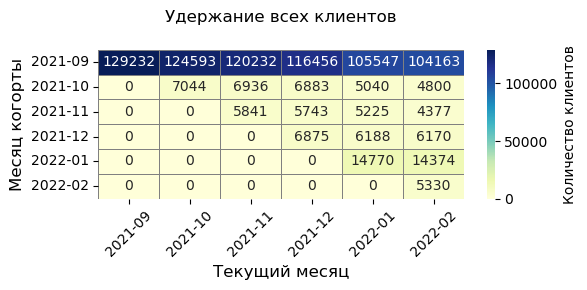

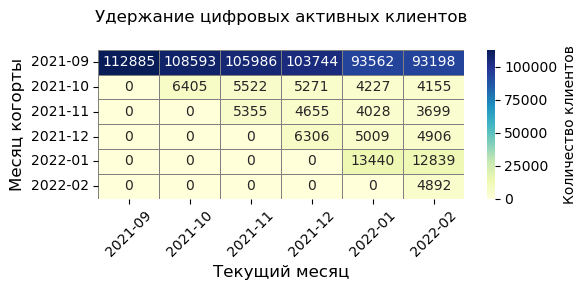

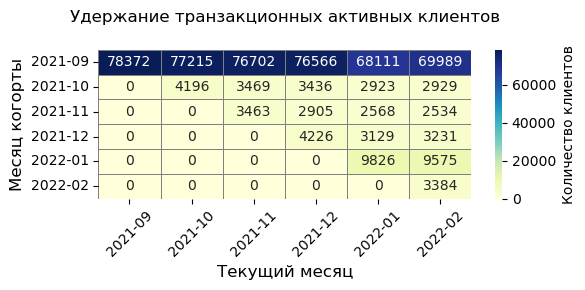

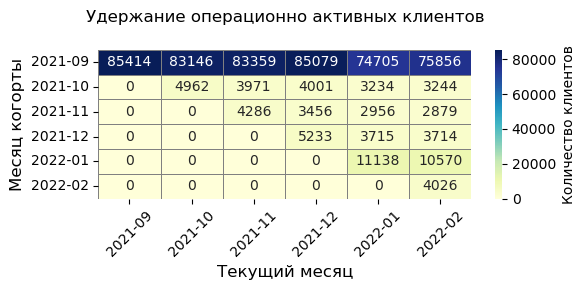

In [38]:
def plot_retention_matrix(matrix, title):
    plt.figure(figsize=(6, 3))  # Увеличим размер для лучшей читаемости
    sns.heatmap(matrix, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Количество клиентов'}, linewidths=0.5, linecolor='gray')
    
    plt.title(title, pad=20)
    plt.ylabel('Месяц когорты', fontsize=12)
    plt.xlabel('Текущий месяц', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Визуализируем все матрицы
plot_retention_matrix(retention_counts_all, 'Удержание всех клиентов')
plot_retention_matrix(retention_counts_digital, 'Удержание цифровых активных клиентов')
plot_retention_matrix(retention_counts_trans, 'Удержание транзакционных активных клиентов')
plot_retention_matrix(retention_counts_oper, 'Удержание операционно активных клиентов')

Пенетрация транзакционно активных клиентов в когорты диджитал активных клиентов:


order_month,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02
cohort_month,,,,,,
2021-09,69.1,70.8,72.1,73.5,72.5,74.8
2021-10,NaN,64.9,62.4,64.7,68.7,70.1
2021-11,NaN,NaN,64.1,62.0,63.3,68.1
2021-12,NaN,NaN,NaN,66.5,62.0,65.4
2022-01,NaN,NaN,NaN,NaN,72.9,74.3
2022-02,NaN,NaN,NaN,NaN,NaN,68.6


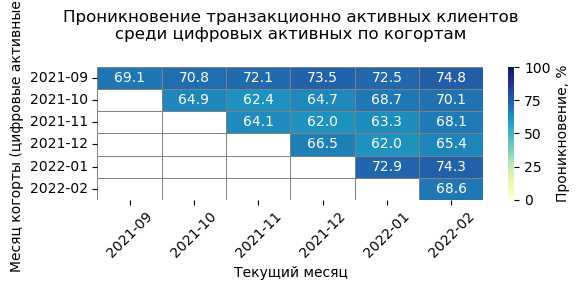

In [39]:
# 1. Создаем когортный анализ для цифровых активных клиентов
digital_cohorts = data[data['is_digital_active']].groupby(
    ['cohort_month', 'order_month']
)['CLIENT_ID'].nunique().unstack()

# 2. Создаем когортный анализ для транзакционно активных среди цифровых
trans_in_digital = data[data['is_digital_active'] & data['is_trans_active']].groupby(
    ['cohort_month', 'order_month']
)['CLIENT_ID'].nunique().unstack()

# 3. Рассчитываем проникновение (доля транзакционных среди цифровых)
penetration = (trans_in_digital / digital_cohorts * 100).round(1)
print("Пенетрация транзакционно активных клиентов в когорты диджитал активных клиентов:")
display(penetration)

# 4. Визуализация
plt.figure(figsize=(6, 3))
sns.heatmap(
    penetration,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    vmin=0,
    vmax=100,
    cbar_kws={'label': 'Проникновение, %'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Проникновение транзакционно активных клиентов\nсреди цифровых активных по когортам', pad=20)
plt.ylabel('Месяц когорты (цифровые активные)')
plt.xlabel('Текущий месяц')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Когорта 2021-09 

В сентябре 2021: 69.1% клиентов, зашедших в приложение, совершили транзак. и

К февралю 2022: доля выросла до .7.8%

Вывод: Удержание транзакционной активности улучшается со временем

Когорта 021-10:

В октябре 2021: 64.9% совершили. ранзакции

К февралю 2022: доля выр.сла до 70.1%

Вывод: Аналогичный тренд роста, но начальное проникновение ниже, чем у когорты 2021-09
 огорта 2022-02:

В феврале 2022: 68.6% новых цифровых клиентов с.вершили транзакции

Вывод: Можно сравнить с другими когортами на том же этапе (например, 2021-09 в феврале 2022 —: 
74.8%)

Общие тренды
Рост проникновения со временем ля большинства когорт:

Клиенты со временем чаще начинают совершать транзакции (возможно, благодаря  аптации или маркетингу).

Например, когорта 2021-09: с 69.1% → 74.8%.

Снижение начального роникновения у новых коорт:

2021-09: 69.1% (старт)

2022-02: - 8.6% (старт)

Возможные причины:

- зменился профиль новых пользователе- 

Снизила необходимо сравнитьвность онбординга

Сезонность:

Сравните когорты в одинаковые периоды (например, декабрьские — 2021-12 стартует с 66.5%).

Рекомендации для бизнеса
Улучшение онбординга для новых когорт:

Почему проникновение в первы месяц падает (2021-09: 69.1% → 2022-02: 68.6%)?

Возможно, нужно упростить первуютранзакцию.

Удержание транзакционной анеобходимо ктивносовать

Для старых когорт проникновение растет — исполНеобходимо проазуйтеировать эти усышые практики для новых пользователей.

Анализ выбросов:

Например, у когорты 2021-11 проникновение в 2021-11 — 64.1%, но затем падает до 62.0%. Почему?

1. Улучшение первого опыта (Onboarding)
Проблема: Низкое начальное проникновение в новых когортах (68.6% в 2022-02 vs 69.1% в 2021-09).
Решени:

Геймификация первой транзакии:

Вознаграждение за первую операцию (бонусы, кэшбэк 200% на первый патеж)

Квест "Соверши 3 платежа в первую неделю → получи премиумстатус"

Упрощениепроцесса:

Автоподстановка реквизитов для частых платежей (ЖКХ, мобиьная связь)

Видео-инструкции с примерами операций прям в интерфейсе

Пример: Когорта 2022-02 стартовала с 68.6%. Внедрение бонуса за первую транзакцию может увеличить показатель до 75+%.

2. Стимулирование повторных транзакций
Проблема: У некоторых когорт проникновение сначала падает (2021-11: с 64.1% о 62.0%).
Решения:

Персонализрованные предложения:

Если пользователь пополнил мобильный → предложить втоплатеж со скидкой 5%

Анализ поведения: для клиентов, которые смотрят валюту, преложить обмен без комисси

Триггерные уведомления:

"У вас осталось 1000₽ — возможно пополниь карту?" при балансе < 1500₽

"Через 3 дня списывается платёж за одписку — подтвердите операцию"

Кейс: Когорта 2021-11 восстановила проникновение до 68.1% через 3 месяца — вероятно, сработали триггеры.

3. Повышение вовлеченности (для "цифровых, но не транзакционных")
Целевая группа: 25-30% digital-активных, кто е совершает транзакций.
Инструменты:
Нетранзакционные активности как вход:

Запуск "финансового здоровья" (анализ расходо) → предложение оптимизации через платежи

Бесплатный кредитнй рейтинг → предожение кредитных продуктов

Микро-действия:

"Добавьте 1 полчателя в адресную книгу → получите 50₽ на счет"

"Просмотрте курс валют → разблокируйте обмен без комиссии"

Эффект: Когорта 2021-12 показала рост с 66.5% до 65.4% — такие инструменты могут ускорить рост

4. Технические улучшения
Устранение точек трения:

A/B-тестирование: сравните кнверсию в платеж между старой и новой версией интерфейса

птимизация времени загрузки экрана патежей (цель < 1 сек)

Интеграция с популярными сервиами:

Встроенные платежи в мессенджерах (Telgram, WhatsApp)

Автоплатежи для стримингов (Netflix, Spotify)

Пример: После оптимизации экрана перевода в другом банке конверия выросла на 12%.

5. Сегметация и персонализация
Как применять:

Выделите группы по поведению

"Просматривают баланс, но не платят" → push-уведомления с подскзками

"Платили 1 раз и ушл" → email с инструкцией "Как платить быстре"

Персонализированный контент:

Для молоды клиентов — кэшбэк за такси/еду

Для старших — упрощенный интерфейс оплаты ЖКУ

Данные: Когорта 2022-01 имеет высокое проникновение (72.9%) — возможно, там преобладают сегменты с естественнойсклонностью к транзакциям.

6. Мониторинг и A/Bтестирование
Метрики для контроля:

Проникновение на 1-й/7-/30-й день жизи когорты

Конверсия из "просмотра экраа платежа" → "успешная операция"

Пример теста:

Группа A получает стандартный онбординг

Группа B: получает :
ерсонализированные подсказки по платежам

Цель: разница в проникновении ≥5%

Ожидаемый результат
ри комплексном внедрении можно добиться:

+10-15% проникновения для новых когорт с 68.6% до 75-80%)

Снижение оттока транзакционных

Важно: Измеряйте impact каждого изменения на отдельных когортах, чтобы найти самые эффективные инструменты.